# How To Build a Kick-Ass Mobile Document Scanner in Just 5 Minutes

## 5分钟内构建强大的移动文档扫描仪

原文作者 Adrian Rosebrock 写于 2014年9月1日
    
本文译于2021年1月19日

https://www.pyimagesearch.com/2014/09/01/build-kick-ass-mobile-document-scanner-just-5-minutes/

![](./img/receipt-scanned.jpg)

使用OpenCV构建文档扫描仪仅需三个简单步骤即可完成：

* 步骤1：边缘检测。

* 步骤2：利用图像中的边缘找到要扫描的纸张的轮廓（线）。

* 步骤3：应用透视变换获得文档的俯视图。

仅需三个步骤，您就可以将自己的文档扫描应用程序提交到应用商店。

OpenCV and Python versions:

本文运行于 Python 3.8.5 和 OpenCV 4.0.1

在所有计算机视觉和图像处理项目中都使用的我自己的[`transform.py`](https://www.pyimagesearch.com/2014/08/25/4-point-opencv-getperspective-transform-example/)模块

运行下一行代码可以展示透视效果

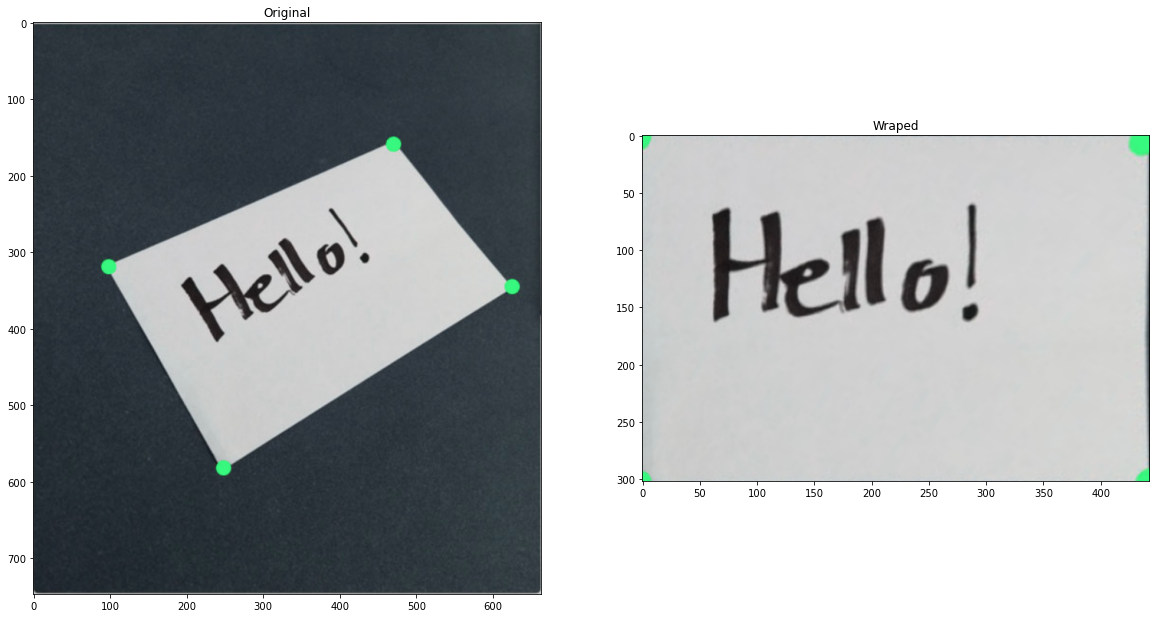

In [1]:
# import 必要的包
from transform import four_point_transform
import numpy as np
import argparse
import cv2
from matplotlib import pyplot as plt
# 加载图像并获取源坐标（即（x，y））
# 让我们开始吧。在以后的文章中，我将向您展示如何
# 自动确定坐标而无需预先提供
image = cv2.imread("./img/sample.png")
pts = np.array([(99, 318), (471, 156), (624, 345), (248, 581)], dtype = "float32")
# 应用四点变换获得“鸟瞰”图片
warped = four_point_transform(image, pts)
# 显示原图和扭曲后的图片
plt.figure(figsize=(20,20))
plt.subplot(121)
plt.title("Original")
plt.imshow(image)
plt.subplot(122)
plt.title("Wraped")
plt.imshow(warped)

每当需要执行4点透视变换时，都应使用此模块。

我们将用它来构建我们自己的文档扫描仪（因为被扫描的文档和镜头并不一定是平行的）。

In [2]:
# import 必要的包
from skimage.filters import threshold_local
import imutils

我们从导入上面`transform.py`的`four_point_transform`函数开始。

我们还将使用imutils模块，该模块包含用于调整图像大小，旋转和裁剪的便捷功能。

您可以在[这篇文章](https://pyimagesearch.com/2015/02/02/just-open-sourced-personal-imutils-package-series-opencv-convenience-functions/)中了解有关imutils的更多信息。

要安装imutils，只需：`pip install --upgrade imutils`

接下来，让我们从[`scikit-image`](http://scikit-image.org/)导入`threshold_local`函数。此功能将帮助我们获得扫描图像的“黑白”感觉。

注意（2018年1月15日）：不建议使用`threshold_adaptive`函数。该帖子已更新为可以使用`threshold_local`。

最后，我们将使用NumPy进行数值处理，并使用cv2进行OpenCV绑定。

现在我们可以继续进行步骤1：边缘检测。

## Step 1: 边缘检测

使用OpenCV构建文档扫描仪应用程序的第一步是边缘检测。

首先，我们将从磁盘加载图片。

为了加快图像处理速度，并使边缘检测步骤更加准确，我们在将扫描图像的大小调整为500像素的高度。

我们还特别注意跟踪图像原始高度与新高度的比率-这将使我们能够对原始图像执行扫描，而无需调整大小。

从那里开始，我们在将图像从RGB转换为灰度，执行高斯模糊以消除高频噪声（有助于步骤2中的轮廓检测），并在执行Canny边缘检测。

然后，显示Setp 1的输出。

STEP 1: Edge Detection


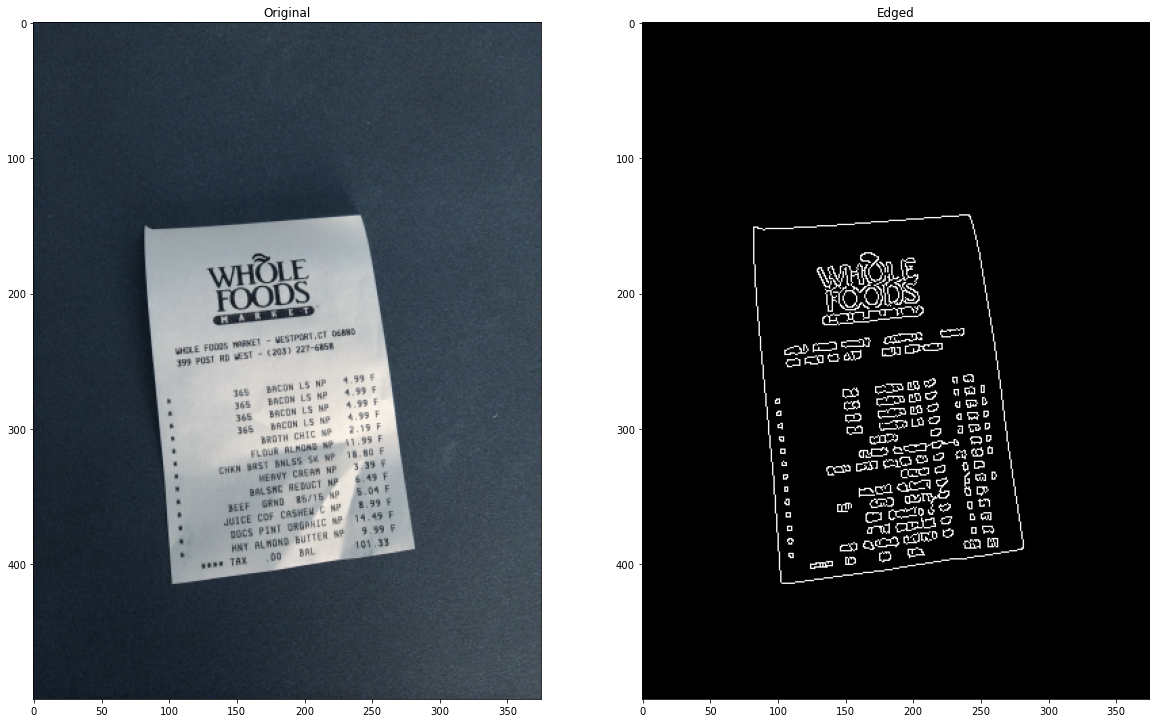

In [3]:
# 加载图像并计算旧高度和新高度的比例
# 复制它，并调整其大小
image = cv2.imread("./img/receipt.jpg")
ratio = image.shape[0] / 500.0
orig = image.copy()
image = imutils.resize(image, height = 500)
# 将图像转换为灰度图，使其高斯模糊并找到其边缘
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)
edged = cv2.Canny(gray, 75, 200)
# 展示原始图像和边缘检测图像
print("STEP 1: Edge Detection")
plt.figure(figsize=(20,20))
plt.subplot(121)
plt.title("Original")
plt.imshow(image)
plt.subplot(122)
plt.title("Edged")
plt.imshow(edged,cmap='gray')

这张图片中的收据有一些倾斜，不是严格的自上而下的视图，而且图片中也有一部分是桌面。从右边的图片可以清晰地看到收据的边缘。

## Step 2:寻找轮廓

文档扫描器是扫描一张纸，这是一个有四个角的矩形框，所以可以假设图像中最大的四角轮廓就是我们要扫描的纸。

这也可以被称为启发式方法，启发式方法指人在解决问题时所采取的一种根据经验规则进行发现的方法。

通过 `cv2.findContours` 在边缘图像中找到很多轮廓（不同的 OpenCV 版本该函数的返回值不同，这点要注意）

对得到的这些轮廓根据面积降序排序，并只保留前五个轮廓，其他的轮廓就丢弃。

然后通过 `for` 循环遍历每个轮廓，用更少的点去逼近轮廓，即用更少的点来近似描绘出相同形状的轮廓。

如果近似轮廓有四个点，那么就认为这个轮廓是我们要找的文档轮廓。

我们找出的文档轮廓如下所示：

STEP 2: Find contours of paper


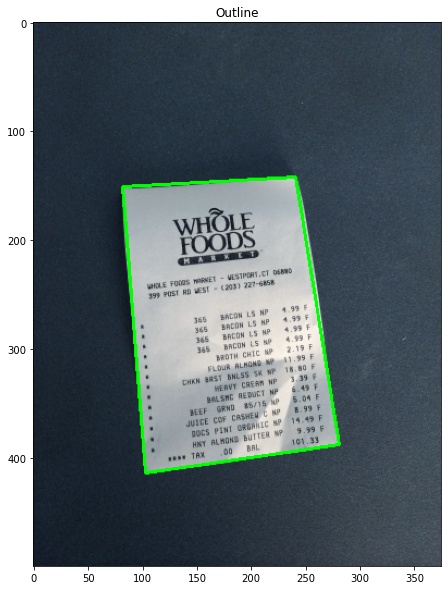

In [4]:
# 在边缘图像中找到轮廓，仅保留
# 1个最大的，并初始化屏幕轮廓
cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:5]
# 遍历所有轮廓
for c in cnts:
	# 近似轮廓
	peri = cv2.arcLength(c, True)
	approx = cv2.approxPolyDP(c, 0.02 * peri, True)
    # 如果我们的近似轮廓有四个点，那么我们
    # 可以假设我们已经找到我们的目标
	if len(approx) == 4:
		screenCnt = approx
		break
# show the contour (outline) of the piece of paper
print("STEP 2: Find contours of paper")
cv2.drawContours(image, [screenCnt], -1, (0, 255, 0), 2)
plt.figure(figsize=(10,10))
plt.title("Outline")
plt.imshow(image)

## Step 3:应用透射变换/阈值

这一步需要做的是获取表示文档轮廓的四个点，然后使用透视变换来得到自上而下的“鸟瞰”图。

STEP 3: Apply perspective transform


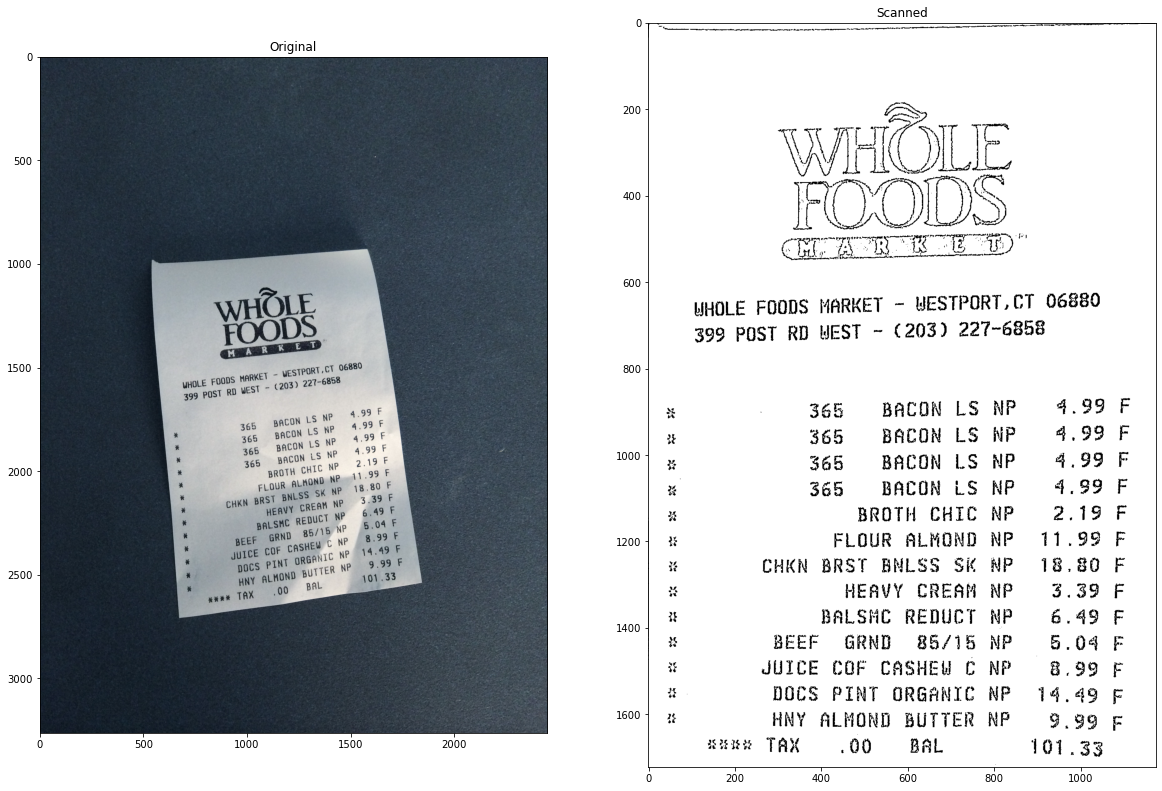

In [5]:
# 应用四点变换以获得鸟瞰图
warped = four_point_transform(orig, screenCnt.reshape(4, 2) * ratio)
# 将变形的图像转换为灰度，然后对其进行阈值处理
# 以赋予其“黑白”纸效果
warped = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
T = threshold_local(warped, 11, offset = 10, method = "gaussian")
warped = (warped > T).astype("uint8") * 255
# 显示原始和扫描图像
print("STEP 3: Apply perspective transform")
plt.figure(figsize=(20,20))
plt.subplot(121)
plt.title("Original")
plt.imshow(orig)
plt.subplot(122)
plt.title("Scanned")
plt.imshow(warped,cmap='gray')

最后扫描图像的视图发生了变化，是一个自上而下的“鸟瞰”图。

多亏了自适应阈值处理，使最后的文档看起来有一种很好的、干净的黑白感觉。